Aplicación de metodologías de cálculo de probabilidad de default para los bonos argentinos

In [1]:
#Importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import interpolate
from scipy.optimize import newton
import pandas_datareader as pdr
import datetime


In [2]:
#Importo la información: Precios y Cashflows de los bonos soberanos argentinos


Bonds_LocalLaw = ['AL29', 'AL30', 'AL35', 'AE38', 'AL41']
Bonds_ForeignLaw = ['GD29', 'GD30', 'GD35', 'GD38', 'GD41', 'GD46']

Bonds = Bonds_LocalLaw + Bonds_ForeignLaw

excel = 'Input.xlsx'

#Importo los cash flows de los bonos Argentinos

data_frames = []

for i in Bonds:
    sheet = i
    df = pd.read_excel(excel, sheet_name=sheet, index_col='Fecha Pago')
    df.index = pd.to_datetime(df.index)
    data_frames.append({i: df})

Bonds_CashFlows = {nombre: dataframe for elemento in data_frames for nombre, dataframe in elemento.items()}


#Importo los precios diarios de los bonos argentinos

sheet_AL = 'PRICES Local Law'
sheet_GD = 'PRICES Foreign Law'
data_frames = []

df_AL = pd.read_excel(excel, sheet_name=sheet_AL, index_col='date')

for i in Bonds_LocalLaw:
    df = df_AL[i]
    df = pd.DataFrame(df)
    df.index = pd.to_datetime(df.index)
    data_frames.append({i: df})

df_GD = pd.read_excel(excel, sheet_name=sheet_GD, index_col='date')

for i in Bonds_ForeignLaw:
    df = df_GD[i]
    df = pd.DataFrame(df)
    df.index = pd.to_datetime(df.index)
    data_frames.append({i: df})

Bonds_Prices = {nombre: dataframe for elemento in data_frames for nombre, dataframe in elemento.items()}




In [3]:
# Importo el Riesgo País
sheet = 'Country Risk'
CR = pd.read_excel(excel, sheet_name=sheet, index_col='date')
CR.index = pd.to_datetime(CR.index)


In [4]:

# Importar curva de tasas de interés desde FRED (Api de la FED)

#Tickers de los Bonos del Tesoro Americano de cada vencimiento
t1m = 'DGS1MO'
t3m = 'DGS3MO'
t6m = 'DGS6MO'
t1y = 'DGS1'
t2y = 'DGS2'
t3y = 'DGS3'
t5y = 'DGS5'
t7y = 'DGS7'
t10y = 'DGS10'
t20y = 'DGS20'
t30y = 'DGS30'

# Fecha de inicio y fecha de fin para los datos históricos.

start_date = datetime.date(2020, 9, 1)
end_date = datetime.date(2023, 10, 26)

# Obtener datos de la curva de tasas de interés desde FRED
nodo1m = pdr.get_data_fred(t1m, start_date, end_date)
nodo3m = pdr.get_data_fred(t3m, start_date, end_date)
nodo6m = pdr.get_data_fred(t6m, start_date, end_date)
nodo1y = pdr.get_data_fred(t1y, start_date, end_date)
nodo2y = pdr.get_data_fred(t2y, start_date, end_date)
nodo3y = pdr.get_data_fred(t3y, start_date, end_date)
nodo5y = pdr.get_data_fred(t5y, start_date, end_date)
nodo7y = pdr.get_data_fred(t7y, start_date, end_date)
nodo10y = pdr.get_data_fred(t10y, start_date, end_date)
nodo20y = pdr.get_data_fred(t20y, start_date, end_date)
nodo30y = pdr.get_data_fred(t30y, start_date, end_date)


In [5]:
# Busco armar un Data Frame que contenga para cada fecha las tasas correspondientes de los títulos del tesoro americano
# para poder inferir a partir de dichos nodos la curva Spot de cada momento.

#Armo rangos de fechas que quisiera tener una ETTI, pongo todos los días hasta los fines de semana para evitar el error en los que hubo
#feriado en USA y no en Argentina y viceversa

fechas_intermedias = [start_date + datetime.timedelta(days=d) for d in range((end_date - start_date).days + 1)]
fechas_intermedias
fechas = pd.DataFrame({'Fecha': fechas_intermedias})
fechas = fechas.set_index('Fecha')
fechas

Curvas = fechas
Curvas = Curvas.join(nodo1m, how="left")
Curvas = Curvas.join(nodo3m, how="left")
Curvas = Curvas.join(nodo6m, how="left")
Curvas = Curvas.join(nodo1y, how="left")
Curvas = Curvas.join(nodo2y, how="left")
Curvas = Curvas.join(nodo3y, how="left")
Curvas = Curvas.join(nodo5y, how="left")
Curvas = Curvas.join(nodo7y, how="left")
Curvas = Curvas.join(nodo10y, how="left")
Curvas = Curvas.join(nodo20y, how="left")
Curvas = Curvas.join(nodo30y, how="left")
Curvas = Curvas.fillna(method='ffill')
nuevos_nombres = {'DGS1MO': 30, 'DGS3MO': 90, 'DGS6MO': 180, 'DGS1': 365, 'DGS2': 730, 'DGS3': 1095, 'DGS5': 1825, 'DGS7': 2555, 'DGS10': 3650, 'DGS20': 7300, 'DGS30': 10950}
Curvas.rename(columns=nuevos_nombres, inplace=True)

In [6]:
#Buscando la ETTI Risk Free de USA.

#Función utilizada para ver gráficamente cómo sería la interpolación

def EjemploSplineInterpolator(x, y):
    tck1 = interpolate.splrep(x, y, s=0)
    xForPlot = np.linspace(0, 10950, num=10951, endpoint=True)
    yForPlot1 = interpolate.splev(xForPlot, tck1, der=0)
    plt.figure(4)
    plt.plot(x, y, 'o', linewidth=0, label="data")
    plt.plot(xForPlot, yForPlot1, '-', label="Spline smoothness=0")
    plt.legend()

    # Personalizar el gráfico
    plt.title('Curva Spot')
    plt.xlabel('Día')
    plt.ylabel('Tasa de interés')
    plt.grid(True)

    plt.show()



#Armo función que permita interpolar la función spot e indique el valor de dicha curva en una fecha o día determinado

def interpolador(date, historical_rates):
    date = pd.to_datetime(date)
    x = historical_rates.columns.to_list()
    y = historical_rates.loc[date].to_list()
    tck = interpolate.splrep(x, y, s=0)
    return tck



In [7]:
#Recovery Rate Definido
RR = 0.3

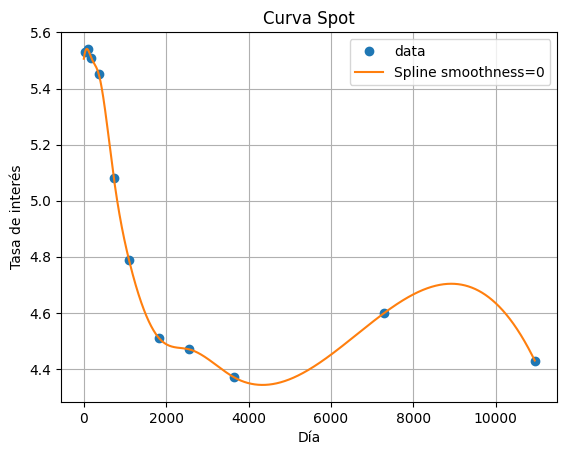

In [8]:
EjemploSplineInterpolator(Curvas.columns,Curvas.loc['2023-09-19'])

Modelo de probabilidad Marginal / Incondicional

In [9]:
#Creo función para calcular el Net Present Value (NPV) o valor presente neto risk free de un bono a cada fecha

def NPV(cf, date, historical_rates):

    #cf: corresponde al data frame con los flujos de fondos y fechas de pago contractuales
    #date: fecha en la cual voy a estar calculando el valor del bono
    #historical_rates: corresponde al data frame que contiene información histórica respecto a los nodos
    #de la curva risk free a cada fecha

    date = pd.to_datetime(date)
    cf2 = cf.loc[cf.index > date, ['A+R']]
    #La columna 'A+R' corresponde al flujo de fondos total correspondiente a la suma de la amortización y el interés
    cf2['Dias al pago'] = (cf2.index - date).days
    cf2['Tasa Risk Free'] = interpolate.splev(cf2['Dias al pago'],interpolador(date, historical_rates))/100
    cf2['Factor de Actualizacion'] = (1 + cf2['Tasa Risk Free'] )**-(cf2['Dias al pago']/365)
    cf2['Valor Actual del Flujo de Fondos'] = cf2['A+R'] * cf2['Factor de Actualizacion']
    precio = sum(cf2['Valor Actual del Flujo de Fondos'])
    return precio

NPV(Bonds_CashFlows['AL30'], '2023-09-19' , Curvas )


87.39974680799335

In [10]:
#Considerando una fecha “x” determinada se ha definido la función NPV_Forward para que pueda calcular el
# precio risk-free del bono en cada fecha de pago de cupón.

def NPV_Forward(cf, date, date_forward, historical_rates):

    #cf: corresponde al data frame con los flujos de fodos y fechas de pago contractuales

    #date: fecha en la cual voy a estar buscando saber la probabilidad de default.
    #Este dato es útil dado que indica que se estará utilizando la curva spot a dicha fecha

    #date_forward: fecha posterior a "date" en la cual se estará calculando el precio risk-free a partir de
    #la curva forward que se desprende de la curva spot de date

    #historical_rates: corresponde al data frame que contiene información histórica respecto a los nodos
    #de la curva risk free a cada fecha

    date = pd.to_datetime(date)
    cf2 = cf.loc[cf.index > date, ['A+R']]
    date_forward = pd.to_datetime(date_forward)
    cf2 = cf2.loc[cf2.index >= date_forward, ['A+R']]
    cf2['Dias al pago'] = (cf2.index - date).days
    cf2['Tasa Risk Free'] = interpolate.splev(cf2['Dias al pago'],interpolador(date, historical_rates))/100
    cf2['Tasa Forward Risk Free'] = ((1+ cf2['Tasa Risk Free'])**(cf2['Dias al pago']/365) / (1+ cf2['Tasa Risk Free'][0])**(cf2['Dias al pago'][0]/365))**(365/(cf2['Dias al pago'] - cf2['Dias al pago'][0])) -1
    cf2['Factor de Actualizacion'] = (1 + cf2['Tasa Forward Risk Free'])**-((cf2['Dias al pago']-cf2['Dias al pago'][0])/365)
    cf2['Valor Presento del Flujo de Fondos'] = cf2['A+R'] * cf2['Factor de Actualizacion']
    price = sum(cf2['Valor Presento del Flujo de Fondos'])
    return price

NPV_Forward(Bonds_CashFlows['AL30'], '2023-09-19' , Bonds_CashFlows['AL30'][Bonds_CashFlows['AL30'].index > pd.to_datetime('2023-09-19')].index[2], Curvas )

88.70534182659152

df = pd.DataFrame(interpolador('19-9-2023', Curvas)[0:2], columns=['Columna1', 'Columna2'])
df
interpolador('19-9-2023', Curvas)
#to_excel('C:/Users/juana/OneDrive/UCEMA/Quant - Finanzas Cuantitativas/TP Final/tuplas.xlsx', index=False)

In [11]:
#Armo función para calcular el valor actual de la pérdida a cada fecha que luego me servirá para calcular la PD

def LossPV(cf, date, historical_rates):

    #cf: corresponde al data frame con los flujos de fodos y fechas de pago contractuales

    #date: fecha en la cual voy a estar buscando saber la probabilidad de default.
    #Este dato es útil dado que indica que se estará utilizando la curva spot a dicha fecha

    #historical_rates: corresponde al data frame que contiene información histórica respecto a los nodos
    #de la curva risk free a cada fecha

    date = pd.to_datetime(date)
    cf2 = cf.loc[cf.index > date, ['VR','A+R']]
    #La columna 'VR' corresponde al valor residual del bono a cada momento
    cf2['Precio Risk Free'] = [NPV_Forward(cf, date, dates, historical_rates) for dates, cupon in cf2.iterrows()]
    cf2['Recovery'] = cf2['VR'] * RR
    cf2['Perdida en Default'] = cf2['Precio Risk Free'] - cf2['Recovery']
    cf2['Dias al pago'] = (cf2.index - date).days
    cf2['Tasa Risk Free'] = interpolate.splev(cf2['Dias al pago'],interpolador(date, historical_rates))/100
    cf2['Factor de actualizacion'] = (1 + cf2['Tasa Risk Free'] )**-(cf2['Dias al pago']/365)
    cf2['Valor actual de la perdida'] = cf2['Factor de actualizacion'] * cf2['Perdida en Default']
    PVDL = sum(cf2['Valor actual de la perdida'])
    return PVDL

LossPV(Bonds_CashFlows['AL30'],'2023-09-19', Curvas)


470.15073323917346

In [12]:
# Creo función para poder calcular las PDs históricos del bono

def PDs(historical_prices, cf, historical_rates):

    #historical_prices: sería la matriz de precios y fechas del activo

    #cf: corresponde al data frame con los flujos de fodos y fechas de pago contractuales

    #historical_rates: corresponde al data frame que contiene información histórica respecto a los nodos
    #de la curva risk free a cada fecha

    summary = historical_prices
    summary['Precio Risk Free'] = [NPV(cf, dates, historical_rates) for dates, prices in summary.iterrows()]
    summary['Spread Crediticio'] = summary['Precio Risk Free'] - summary.iloc[:, 0]
    summary['Valor actual de la perdida'] = [LossPV(cf, dates, historical_rates) for dates, prices in summary.iterrows()]
    summary['Probabilidad de Default'] = summary['Spread Crediticio'] / summary['Valor actual de la perdida'] * 2
    Default_Prob = summary['Probabilidad de Default']
    Default_Prob = pd.DataFrame(Default_Prob)
    Default_Prob.columns = [summary.columns[0]]
    return Default_Prob

PDs(Bonds_Prices['AL30'], Bonds_CashFlows['AL30'], Curvas)

AL30
date                
2020-09-14  0.107114
2020-09-15  0.108816
2020-09-16  0.115489
2020-09-17  0.117772
2020-09-18  0.117305
...              ...
2023-10-20  0.253328
2023-10-23  0.270195
2023-10-24  0.262888
2023-10-25  0.262451
2023-10-26  0.264838

[761 rows x 1 columns]

In [13]:
#Armo Data Frame que contenga la evolucion de las PDs de los bonos soberanos ley local y extranjero

PDs_LocalLaw = pd.DataFrame()

for i in Bonds_LocalLaw:
    PDs_LocalLaw[i] = PDs(Bonds_Prices[i], Bonds_CashFlows[i], Curvas)

PDs_LocalLaw

PDs_ForeignLaw = pd.DataFrame()

for i in Bonds_ForeignLaw:
    PDs_ForeignLaw[i] = PDs(Bonds_Prices[i], Bonds_CashFlows[i], Curvas)

PDs_ForeignLaw

GD29      GD30      GD35      GD38      GD41      GD46
date                                                                  
2020-09-14  0.113340  0.111136  0.082928  0.083893  0.076028  0.073700
2020-09-15  0.113343  0.111138  0.082929  0.083894  0.076029  0.073704
2020-09-16  0.119526  0.115188  0.084766  0.085867  0.077898  0.073740
2020-09-17  0.126301  0.119171  0.086139  0.086333  0.079664  0.074224
2020-09-18  0.125264  0.117757  0.086588  0.087178  0.079677  0.073886
...              ...       ...       ...       ...       ...       ...
2023-10-20  0.265148  0.229041  0.120738  0.118118  0.105707  0.111787
2023-10-23  0.264694  0.252188  0.125196  0.120990  0.105742  0.109869
2023-10-24  0.273979  0.243931  0.124954  0.127104  0.111661  0.116070
2023-10-25  0.276350  0.245270  0.124460  0.125533  0.109852  0.115998
2023-10-26  0.267296  0.248358  0.125956  0.127490  0.109918  0.110884

[761 rows x 6 columns]

In [14]:
#Armo un único Data Frame que contenga los data frames con las PDs con legislación local y extranjera
PDs_Marginales = pd.concat([PDs_LocalLaw, PDs_ForeignLaw], axis=1)

PDs_Mg = PDs_Marginales.copy()
PDs_Mg['PD Promedio'] = PDs_Mg.mean(axis=1)
PDs_Mg = PDs_Mg['PD Promedio']

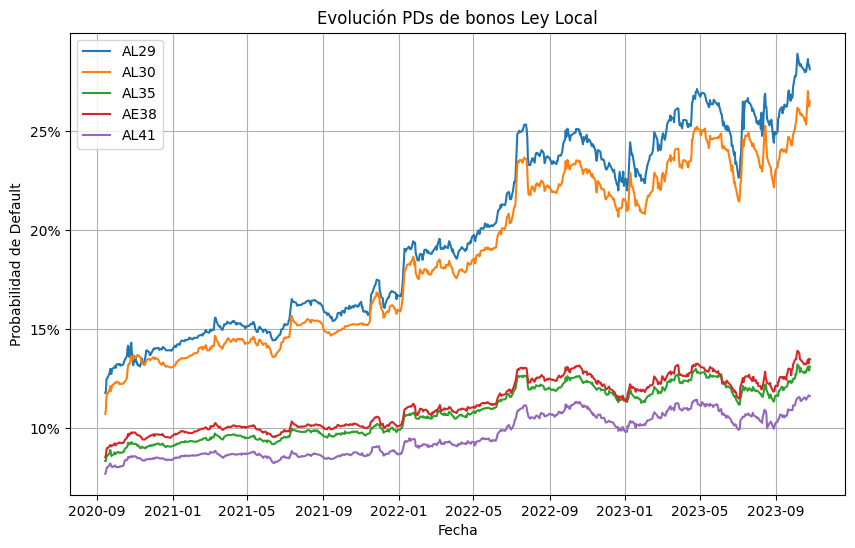

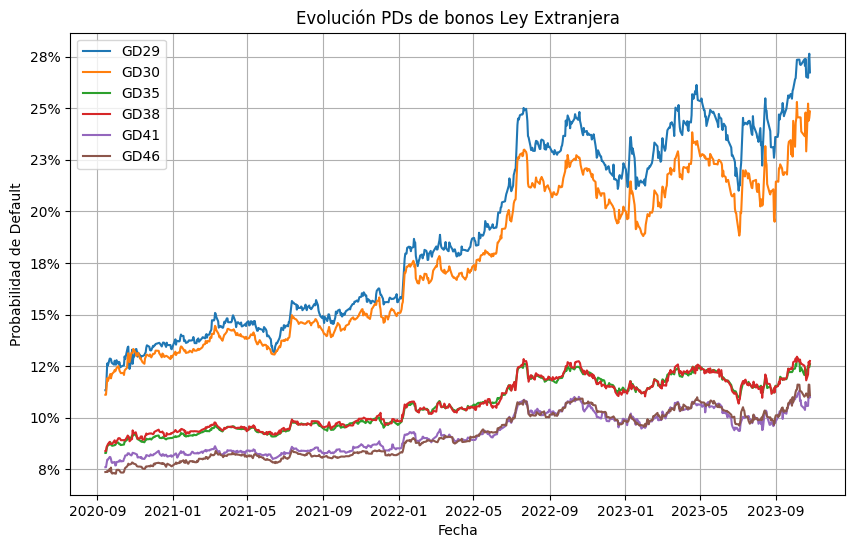

Bond  Correlation
0   AL29     0.909485
1   AL30     0.915257
2   AL35     0.953339
3   AE38     0.946579
4   AL41     0.943730
5   GD29     0.928170
6   GD30     0.944521
7   GD35     0.957987
8   GD38     0.960659
9   GD41     0.963682
10  GD46     0.954461

In [15]:
#Grafico las PDs de cada Bono de Ley Local

# Crear un gráfico de líneas para cada serie con leyenda
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

for i in Bonds_LocalLaw:
    plt.plot(PDs_LocalLaw.index, PDs_LocalLaw[i], label=i)

plt.legend()

# Crear un segundo eje de ordenadas (secundario)
#plt.twinx()

# Agregar la serie secundaria al eje secundario
#plt.plot(CR.index, CR, color='r', label='Country Risk')

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Evolución PDs de bonos Ley Local')
plt.xlabel('Fecha')
plt.ylabel('Probabilidad de Default')
plt.grid(True)

# Formatear el eje y como porcentaje
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.show()

#Grafico las PDs de cada Bono de Ley Extranjera

# Crear un gráfico de líneas para cada serie con leyenda
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

for i in Bonds_ForeignLaw:
    plt.plot(PDs_ForeignLaw.index, PDs_ForeignLaw[i], label=i)

plt.legend()

# Crear un segundo eje de ordenadas (secundario)
#plt.twinx()

# Agregar la serie secundaria al eje secundario
#plt.plot(CR.index, CR, color='r', label='Country Risk')

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Evolución PDs de bonos Ley Extranjera')
plt.xlabel('Fecha')
plt.ylabel('Probabilidad de Default')
plt.grid(True)

# Formatear el eje y como porcentaje
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.show()

#Calculo el coeficiente de Correlación

Correlation_LocalLaw = {'Bond' : [i for i in Bonds_LocalLaw],
        'Correlation' : [CR['ARG'].corr(PDs_LocalLaw[i]) for i in Bonds_LocalLaw]}

Correlation_LocalLaw = pd.DataFrame(Correlation_LocalLaw)


Correlation_ForeignLaw = {'Bond' : [i for i in Bonds_ForeignLaw],
        'Correlation' : [CR['ARG'].corr(PDs_ForeignLaw[i]) for i in Bonds_ForeignLaw]}

Correlation_ForeignLaw = pd.DataFrame(Correlation_ForeignLaw)
Correlation = pd.concat([Correlation_LocalLaw, Correlation_ForeignLaw], ignore_index=True)
Correlation


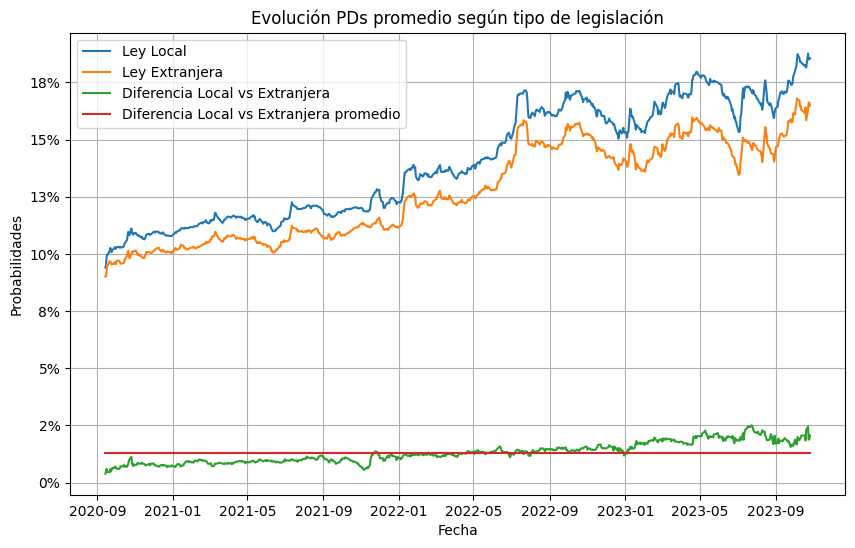

0.013069935184131272

In [16]:
#Graficar La prob promedio de lo que es Ley Local y Ley Extranjera y también el GAP entre ambas
#Graficar el GAP promedio histórico

LL = PDs_LocalLaw.copy()
LL['Local Law Default Probability'] = LL.mean(axis=1)
LL = LL['Local Law Default Probability']

FL = PDs_ForeignLaw.copy()
FL['Foreign Law Default Probability'] = FL.mean(axis=1)
FL = FL['Foreign Law Default Probability']

Law_Gap = LL - FL

# Crear un gráfico de líneas para cada serie con leyenda
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

plt.plot(LL.index, LL, label='Ley Local')
plt.plot(FL.index, FL, label='Ley Extranjera')
plt.plot(Law_Gap.index, Law_Gap, label='Diferencia Local vs Extranjera')
plt.plot(Law_Gap.index, [Law_Gap.mean() for i in range(len(Law_Gap.index))], label='Diferencia Local vs Extranjera promedio')


# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Evolución PDs promedio según tipo de legislación')
plt.xlabel('Fecha')
plt.ylabel('Probabilidades')
plt.grid(True)

# Formatear el eje y como porcentaje
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.show()

Law_Gap.mean()

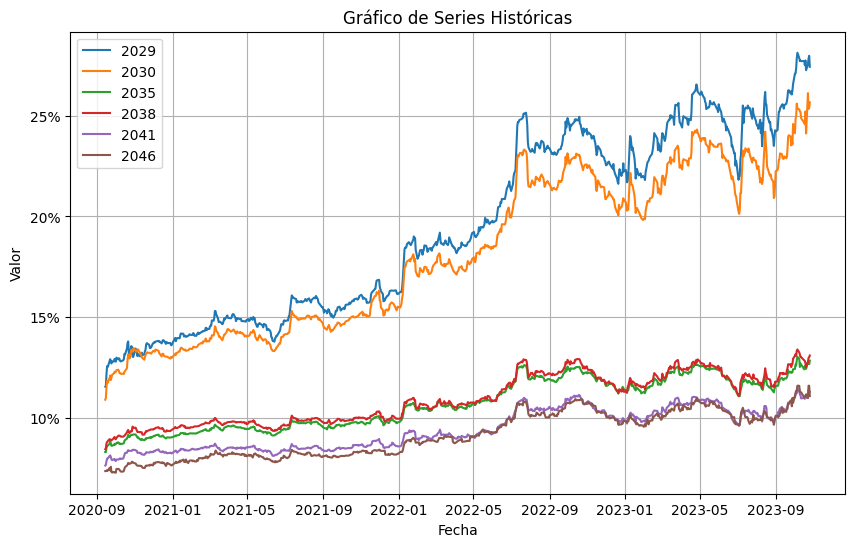

In [17]:
#Graficar la prob promedio según fecha de Vto

# Maturity 2029

PDs_2029 = pd.DataFrame()
PDs_2029['AL29'] = PDs_LocalLaw['AL29']
PDs_2029['GD29'] = PDs_ForeignLaw['GD29']
PDs_2029['2029'] = PDs_2029.mean(axis=1)
PDs_2029 = PDs_2029['2029']

PDs_2030 = pd.DataFrame()
PDs_2030['AL30'] = PDs_LocalLaw['AL30']
PDs_2030['GD30'] = PDs_ForeignLaw['GD30']
PDs_2030['2030'] = PDs_2030.mean(axis=1)
PDs_2030 = PDs_2030['2030']

PDs_2035 = pd.DataFrame()
PDs_2035['AL35'] = PDs_LocalLaw['AL35']
PDs_2035['GD35'] = PDs_ForeignLaw['GD35']
PDs_2035['2035'] = PDs_2035.mean(axis=1)
PDs_2035 = PDs_2035['2035']

PDs_2038 = pd.DataFrame()
PDs_2038['AE38'] = PDs_LocalLaw['AE38']
PDs_2038['GD38'] = PDs_ForeignLaw['GD38']
PDs_2038['2038'] = PDs_2038.mean(axis=1)
PDs_2038 = PDs_2038['2038']

PDs_2041 = pd.DataFrame()
PDs_2041['AL41'] = PDs_LocalLaw['AL41']
PDs_2041['GD41'] = PDs_ForeignLaw['GD41']
PDs_2041['2041'] = PDs_2041.mean(axis=1)
PDs_2041 = PDs_2041['2041']

PDs_2046 = pd.DataFrame()
PDs_2046['GD46'] = PDs_ForeignLaw['GD46']
PDs_2046['2046'] = PDs_2046.mean(axis=1)
PDs_2046 = PDs_2046['2046']

PDs_Maturity = pd.DataFrame()
PDs_Maturity['2029'] = PDs_2029
PDs_Maturity['2030'] = PDs_2030
PDs_Maturity['2035'] = PDs_2035
PDs_Maturity['2038'] = PDs_2038
PDs_Maturity['2041'] = PDs_2041
PDs_Maturity['2046'] = PDs_2046
PDs_Maturity

plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

for i in PDs_Maturity.columns:
    plt.plot(PDs_Maturity.index, PDs_Maturity[i], label=i)

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Gráfico de Series Históricas')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)

# Formatear el eje y como porcentaje
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.show()


MODELO DE PROBABILIDAD CONDICIONAL O DE SUPERVIVENCIA

In [18]:
#Función de cálculo de las probabilidades de default diarias

def PDs_Cond_Dia(bond_name, date, historical_rates):

    #bond_name: corresponde al ticker del bono

    #date: fecha en la cual voy a estar buscando saber la probabilidad de default.
    #Este dato es útil dado que indica que se estará utilizando la curva spot a dicha fecha

    #historical_rates: corresponde al data frame que contiene información histórica respecto a los nodos
    #de la curva risk free a cada fecha

    cash_flow = Bonds_CashFlows[bond_name]
    day = pd.to_datetime(date)
    cash_flow = cash_flow.loc[cash_flow.index > day, ['A+R']]
    cash_flow['conteo'] = range(1,(cash_flow).shape[0]+1)

    cash_flow['Días para el pago'] = (cash_flow.index - day).days
    cash_flow['Tasa Libre de Riesgo'] = interpolate.splev(cash_flow['Días para el pago'],interpolador(day, historical_rates))/100
    cash_flow['Factor de Actualización'] = (1 + cash_flow['Tasa Libre de Riesgo'] )**-(cash_flow['Días para el pago']/365)

    price = Bonds_Prices[bond_name].iloc[:, 0][day]

    # Definir la función objetivo
    def objetivo(q):

        return sum([(cash_flow['A+R'][i]*(1-q/2)**cash_flow['conteo'][i] + cash_flow['A+R'][i] * RR * (1-q/2)**(cash_flow['conteo'][i]-1) * q/2) * cash_flow['Factor de Actualización'][i]  for i in range(len(cash_flow))]) - price

    punto_inicial = 0.0

    resultado = newton(objetivo, punto_inicial, tol=1e-6)

    return resultado

PDs_Cond_Dia('AL30', '2023-09-19', Curvas)

0.29417136968489016

In [19]:
def PDs_Cond_Bono(bond_name):
    df = pd.DataFrame()

    df[bond_name] = [PDs_Cond_Dia(bond_name, Bonds_Prices[bond_name].index[i], Curvas) for i in range(len(Bonds_Prices[bond_name]))]
    df.index = Bonds_Prices[bond_name].index

    return df

PDs_Cond_Bono('AL30')#.to_excel('C:/Users/juana/OneDrive/UCEMA/Quant - Finanzas Cuantitativas/TP Final/GitHub/tp_quant_Git Desktop/Pds_Condicionales.xlsx', index=True)

AL30
date                
2020-09-14  0.106451
2020-09-15  0.108895
2020-09-16  0.118833
2020-09-17  0.122394
2020-09-18  0.121627
...              ...
2023-10-20  0.319248
2023-10-23  0.366451
2023-10-24  0.345217
2023-10-25  0.342962
2023-10-26  0.350898

[761 rows x 1 columns]

In [20]:
PDs_Cond_LocalLaw = pd.DataFrame()

for i in Bonds_LocalLaw:
    PDs_Cond_LocalLaw[i] = PDs_Cond_Bono(i)

PDs_Cond_LocalLaw

PDs_Cond_ForeignLaw = pd.DataFrame()

for i in Bonds_ForeignLaw:
    PDs_Cond_ForeignLaw[i] = PDs_Cond_Bono(i)

PDs_Cond_ForeignLaw

GD29      GD30      GD35      GD38      GD41      GD46
date                                                                  
2020-09-14  0.111761  0.112290  0.107961  0.110084  0.106034  0.116371
2020-09-15  0.111765  0.112294  0.107966  0.110088  0.106039  0.116375
2020-09-16  0.120604  0.118369  0.112556  0.114974  0.111400  0.116254
2020-09-17  0.130887  0.124617  0.116216  0.116217  0.117006  0.118215
2020-09-18  0.129243  0.122339  0.117362  0.118356  0.116889  0.116712
...              ...       ...       ...       ...       ...       ...
2023-10-20  0.311648  0.264066  0.157569  0.148802  0.140116  0.185642
2023-10-23  0.311050  0.316928  0.170983  0.156494  0.140993  0.179219
2023-10-24  0.331508  0.296963  0.170608  0.173524  0.159550  0.209614
2023-10-25  0.336411  0.299300  0.168076  0.168022  0.152483  0.205880
2023-10-26  0.316763  0.307610  0.173272  0.174161  0.153299  0.183504

[761 rows x 6 columns]

In [21]:
#Armo un único Data Frame que contenga los data frames con las PDs con legislación local y extranjera

PDs_Condicionales = pd.concat([PDs_Cond_LocalLaw, PDs_Cond_ForeignLaw], axis=1)
PDs_Cond = PDs_Condicionales.copy()
PDs_Cond['Foreign Law Default Probability'] = PDs_Cond.mean(axis=1)
PDs_Cond = PDs_Cond['Foreign Law Default Probability']


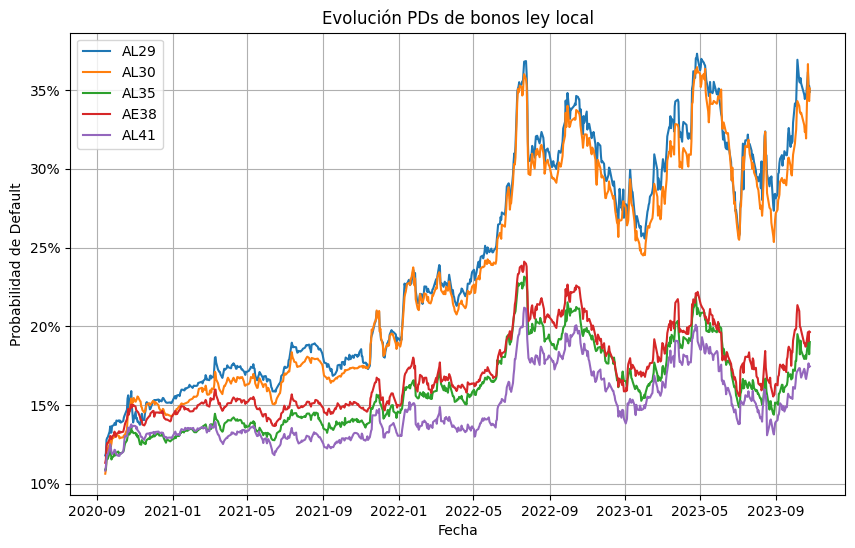

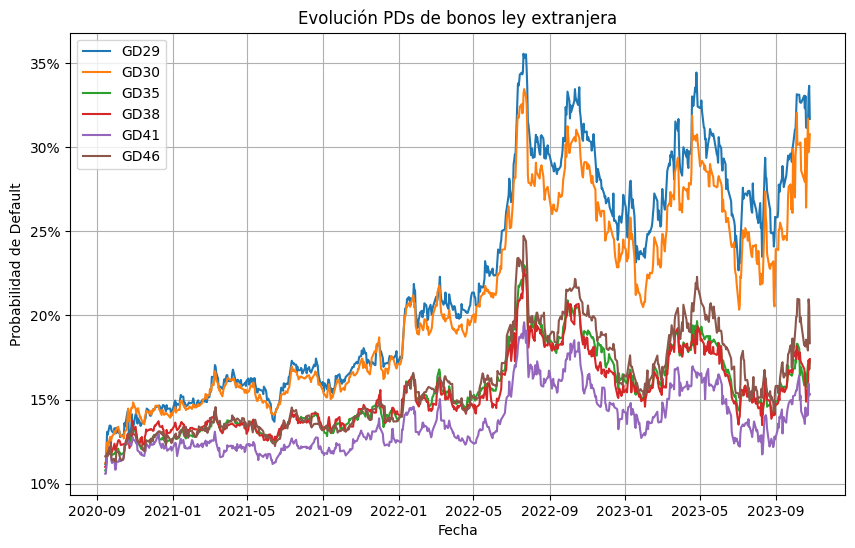

Bond  Correlation
0   AL29     0.962274
1   AL30     0.964324
2   AL35     0.964627
3   AE38     0.955287
4   AL41     0.933401
5   GD29     0.973899
6   GD30     0.983622
7   GD35     0.959552
8   GD38     0.947356
9   GD41     0.928025
10  GD46     0.969917

In [22]:
#Grafico las PDs de cada Bono de Ley Local

# Crear un gráfico de líneas para cada serie con leyenda
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

for i in Bonds_LocalLaw:
    plt.plot(PDs_Cond_LocalLaw.index, PDs_Cond_LocalLaw[i], label=i)

plt.legend()

# Crear un segundo eje de ordenadas (secundario)
#plt.twinx()

# Agregar la serie secundaria al eje secundario
#plt.plot(CR.index, CR, color='r', label='Country Risk')

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Evolución PDs de bonos ley local')
plt.xlabel('Fecha')
plt.ylabel('Probabilidad de Default')
plt.grid(True)

# Formatear el eje y como porcentaje
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.show()

#Grafico las PDs de cada Bono de Ley Extranjera

# Crear un gráfico de líneas para cada serie con leyenda
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

for i in Bonds_ForeignLaw:
    plt.plot(PDs_Cond_ForeignLaw.index, PDs_Cond_ForeignLaw[i], label=i)

plt.legend()

# Crear un segundo eje de ordenadas (secundario)
#plt.twinx()

# Agregar la serie secundaria al eje secundario
#plt.plot(CR.index, CR, color='r', label='Country Risk')

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Evolución PDs de bonos ley extranjera')
plt.xlabel('Fecha')
plt.ylabel('Probabilidad de Default')
plt.grid(True)

# Formatear el eje y como porcentaje
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.show()

#Calculo el coeficiente de Correlación

Correlation_LocalLaw = {'Bond' : [i for i in Bonds_LocalLaw],
        'Correlation' : [CR['ARG'].corr(PDs_Cond_LocalLaw[i]) for i in Bonds_LocalLaw]}

Correlation_LocalLaw = pd.DataFrame(Correlation_LocalLaw)


Correlation_ForeignLaw = {'Bond' : [i for i in Bonds_ForeignLaw],
        'Correlation' : [CR['ARG'].corr(PDs_Cond_ForeignLaw[i]) for i in Bonds_ForeignLaw]}

Correlation_ForeignLaw = pd.DataFrame(Correlation_ForeignLaw)
Correlation = pd.concat([Correlation_LocalLaw, Correlation_ForeignLaw], ignore_index=True)
Correlation

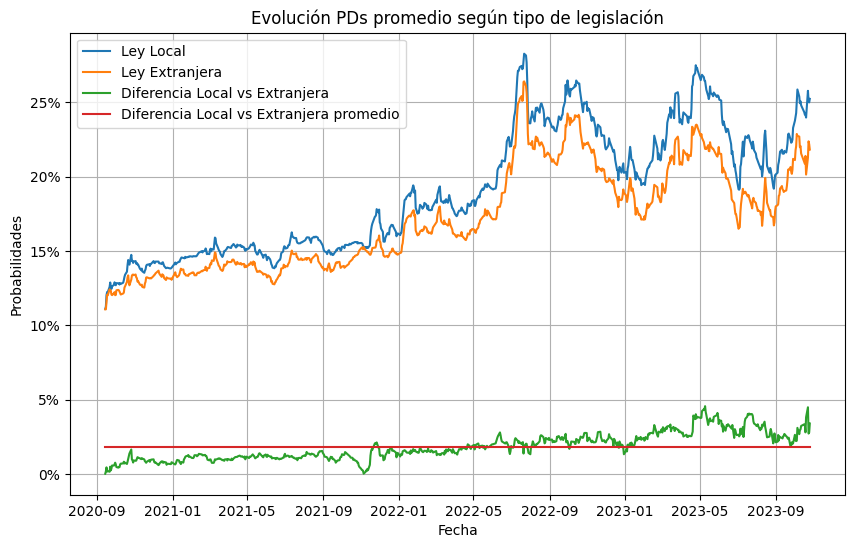

0.01841383330334756

In [23]:
#Graficar La prob promedio de lo que es Ley Local y Ley Extranjera y también el GAP entre ambas
#Graficar el GAP promedio histórico

LL = PDs_Cond_LocalLaw.copy()
LL['Local Law Default Probability'] = LL.mean(axis=1)
LL = LL['Local Law Default Probability']

FL = PDs_Cond_ForeignLaw.copy()
FL['Foreign Law Default Probability'] = FL.mean(axis=1)
FL = FL['Foreign Law Default Probability']

Law_Gap = LL - FL

# Crear un gráfico de líneas para cada serie con leyenda
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

plt.plot(LL.index, LL, label='Ley Local')
plt.plot(FL.index, FL, label='Ley Extranjera')
plt.plot(Law_Gap.index, Law_Gap, label='Diferencia Local vs Extranjera')
plt.plot(Law_Gap.index, [Law_Gap.mean() for i in range(len(Law_Gap.index))], label='Diferencia Local vs Extranjera promedio')


# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Evolución PDs promedio según tipo de legislación')
plt.xlabel('Fecha')
plt.ylabel('Probabilidades')
plt.grid(True)

# Formatear el eje y como porcentaje
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.show()

Law_Gap.mean()

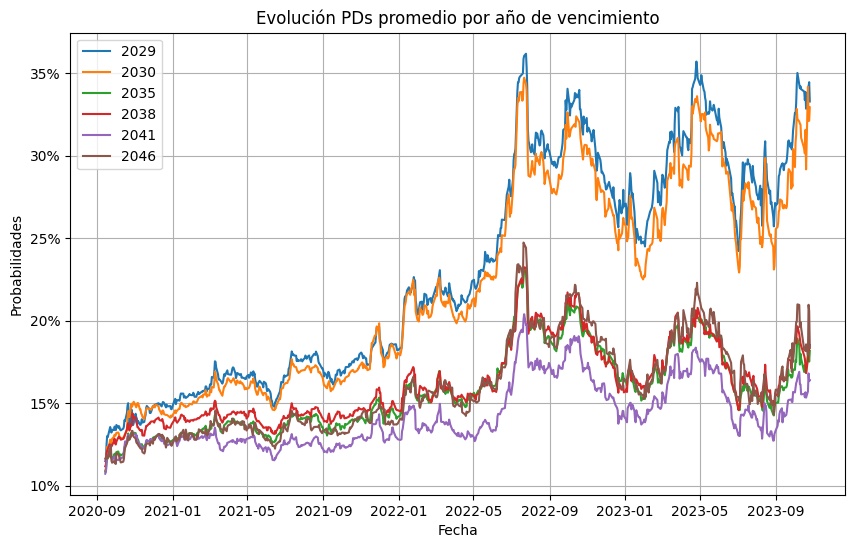

In [24]:
#Graficar la prob promedio según fecha de Vto

# Maturity 2029

PDs_2029 = pd.DataFrame()
PDs_2029['AL29'] = PDs_Cond_LocalLaw['AL29']
PDs_2029['GD29'] = PDs_Cond_ForeignLaw['GD29']
PDs_2029['2029'] = PDs_2029.mean(axis=1)
PDs_2029 = PDs_2029['2029']

PDs_2030 = pd.DataFrame()
PDs_2030['AL30'] = PDs_Cond_LocalLaw['AL30']
PDs_2030['GD30'] = PDs_Cond_ForeignLaw['GD30']
PDs_2030['2030'] = PDs_2030.mean(axis=1)
PDs_2030 = PDs_2030['2030']

PDs_2035 = pd.DataFrame()
PDs_2035['AL35'] = PDs_Cond_LocalLaw['AL35']
PDs_2035['GD35'] = PDs_Cond_ForeignLaw['GD35']
PDs_2035['2035'] = PDs_2035.mean(axis=1)
PDs_2035 = PDs_2035['2035']

PDs_2038 = pd.DataFrame()
PDs_2038['AE38'] = PDs_Cond_LocalLaw['AE38']
PDs_2038['GD38'] = PDs_Cond_ForeignLaw['GD38']
PDs_2038['2038'] = PDs_2038.mean(axis=1)
PDs_2038 = PDs_2038['2038']

PDs_2041 = pd.DataFrame()
PDs_2041['AL41'] = PDs_Cond_LocalLaw['AL41']
PDs_2041['GD41'] = PDs_Cond_ForeignLaw['GD41']
PDs_2041['2041'] = PDs_2041.mean(axis=1)
PDs_2041 = PDs_2041['2041']

PDs_2046 = pd.DataFrame()
PDs_2046['GD46'] = PDs_Cond_ForeignLaw['GD46']
PDs_2046['2046'] = PDs_2046.mean(axis=1)
PDs_2046 = PDs_2046['2046']

PDs_Maturity = pd.DataFrame()
PDs_Maturity['2029'] = PDs_2029
PDs_Maturity['2030'] = PDs_2030
PDs_Maturity['2035'] = PDs_2035
PDs_Maturity['2038'] = PDs_2038
PDs_Maturity['2041'] = PDs_2041
PDs_Maturity['2046'] = PDs_2046
PDs_Maturity

plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

for i in PDs_Maturity.columns:
    plt.plot(PDs_Maturity.index, PDs_Maturity[i], label=i)

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Evolución PDs promedio por año de vencimiento')
plt.xlabel('Fecha')
plt.ylabel('Probabilidades')
plt.grid(True)

# Formatear el eje y como porcentaje
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.show()

In [25]:
#Cálculo de la probabilidad acumulada de supervivencia (pago de cada cupón) del AL30 en el momento de mayor
# y menor valor de PD y calculo la esperanza de vida a dicho momento

#Armo función para poder calcular la evolución de la probabilidad de supervivencia a cada fecha

def Prob_Superv(bond_name, date, PDs_historicas):

    #bond_name: corresponde al ticker del bono

    #date: fecha en la cual voy a estar buscando saber evolución de la probabilidad de supervivencia.

    #PDs_historicas: corresponde al data frame que contiene información histórica de las PDs

    import pandas as pd

    day = pd.to_datetime(date)
    pd = PDs_historicas[bond_name][day]
    cash_flow = Bonds_CashFlows[bond_name].copy()
    cash_flow = cash_flow.loc[cash_flow.index > day, ['A+R']]
    cash_flow['conteo'] = range(1,(cash_flow).shape[0]+1)
    cash_flow['PD'] = pd
    cash_flow['Probabilidad de Supervivencia'] = (1-cash_flow['PD']/2)**cash_flow['conteo']
    return cash_flow['Probabilidad de Supervivencia']

#Armo función para poder calcular la esperanza de vida de un bono en una fecha determinada

def VidaMediaEsperada(bond_name, date, PDs_historicas):

    #bond_name: corresponde al ticker del bono

    #date: fecha en la cual voy a estar buscando calcular la esperanza de vida.

    #PDs_historicas: corresponde al data frame que contiene información histórica de las PDs

    import pandas as pd

    day = pd.to_datetime(date)
    pd = PDs_historicas[bond_name][day]
    cash_flow = Bonds_CashFlows[bond_name].copy()
    cash_flow = cash_flow.loc[cash_flow.index > day, ['A+R']]
    cash_flow['conteo'] = range(1,(cash_flow).shape[0]+1)
    cash_flow['PD'] = pd
    cash_flow['Probabilidad de Supervivencia'] = (1-cash_flow['PD']/2)**cash_flow['conteo']
    esperanza = cash_flow['Probabilidad de Supervivencia'].sum()
    return esperanza

VidaMediaEsperada('AL30', '2023-09-19', PDs_Condicionales)

#Armo función para poder calcular la serie historica de la esperanza de vida de un bono

def Evol_VidaMediaEsperada(bond_name, PDs_historicas):

    #bond_name: corresponde al ticker del bono

    #PDs_historicas: corresponde al data frame que contiene información histórica de las PDs

    df = pd.DataFrame()

    df[bond_name] = [VidaMediaEsperada(bond_name, j, PDs_historicas) for j in PDs_historicas.index ]
    df.index = PDs_historicas.index

    return df

Evol_VidaMediaEsperada('AL30', PDs_Condicionales)


AL30
date                 
2020-09-14  11.495681
2020-09-15  11.372056
2020-09-16  10.886771
2020-09-17  10.719445
2020-09-18  10.755183
...               ...
2023-10-20   4.803397
2023-10-23   4.195607
2023-10-24   4.455707
2023-10-25   4.484561
2023-10-26   4.384074

[761 rows x 1 columns]

In [26]:
#Armo data frame que contenga la evolución de las PDs de todos los tiempos a lo largo del tiempo

Bonos_Esperanza = pd.DataFrame()

for i in PDs_Condicionales.columns:
    Bonos_Esperanza[i] = Evol_VidaMediaEsperada(i, PDs_Condicionales)

Bonos_Esperanza



AL29       AL30       AL35       AE38       AL41       GD29  \
date                                                                           
2020-09-14  10.275019  11.495681  13.931860  14.351831  15.667929  10.538746   
2020-09-15  10.220555  11.372056  13.933394  14.161947  15.420467  10.538549   
2020-09-16   9.876661  10.886771  13.432064  13.455173  14.848564  10.169958   
2020-09-17   9.830005  10.719445  13.401669  13.251651  14.566571   9.761450   
2020-09-18   9.811633  10.755183  13.381111  13.260384  14.578557   9.825346   
...               ...        ...        ...        ...        ...        ...   
2023-10-20   4.300003   4.803397   9.087597   9.101171  10.525740   4.707930   
2023-10-23   4.118305   4.195607   8.644848   8.728706  10.140540   4.715618   
2023-10-24   4.218933   4.455707   8.653451   8.980189   9.961091   4.461081   
2023-10-25   4.216164   4.484561   8.965968   8.706501  10.090880   4.402649   
2023-10-26   4.258573   4.384074   8.657801   8.725228  10.063216   4.642760   

                 GD30       GD35       GD38       GD41       GD46  
date                                                               
2020-09-14  11.203206  14.019570  14.663362  15.947769  15.425365  
2020-09-15  11.202995  14.019192  14.662911  15.947215  15.424983  
2020-09-16  10.908830  13.642931  14.205023  15.336115  15.439457  
2020-09-17  10.616648  13.353071  14.091860  14.734124  15.206402  
2020-09-18  10.721989  13.264119  13.900161  14.746359  15.384578  
...               ...        ...        ...        ...        ...  
2023-10-20   5.668419  10.061331  11.119070  12.302480   9.662764  
2023-10-23   4.836165   9.444601  10.670966  12.236396  10.024238  
2023-10-24   5.130566   9.461102   9.768595  10.956874   8.488913  
2023-10-25   5.094916   9.573618  10.047393  11.418808   8.655496  
2023-10-26   4.970747   9.344721   9.737074  11.363948   9.780659  

[761 rows x 11 columns]

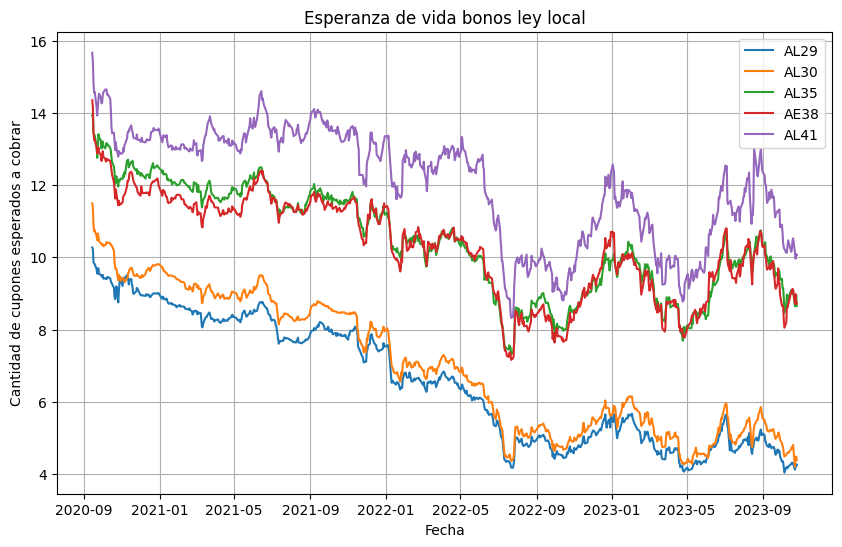

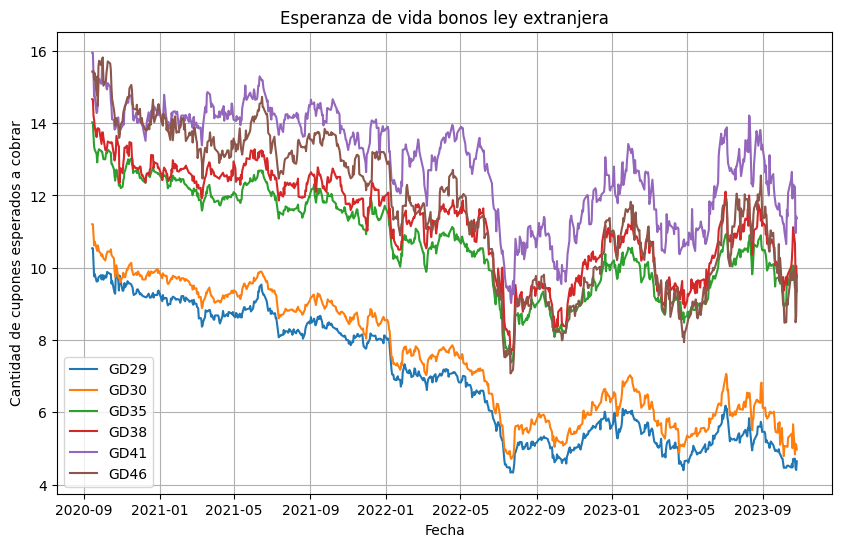

In [27]:
# Graficar las esperanzas de vidas de cada Bono

plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

for i in Bonds_LocalLaw:
    plt.plot(Bonos_Esperanza.index, Bonos_Esperanza[i], label= i)

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Esperanza de vida bonos ley local')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de cupones esperados a cobrar')
plt.grid(True)

# Mostrar el gráfico
plt.show()

# Graficar las esperanzas de vidas de cada Bono

plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

for i in Bonds_ForeignLaw:
    plt.plot(Bonos_Esperanza.index, Bonos_Esperanza[i], label= i)

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Esperanza de vida bonos ley extranjera')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de cupones esperados a cobrar')
plt.grid(True)

# Mostrar el gráfico
plt.show()

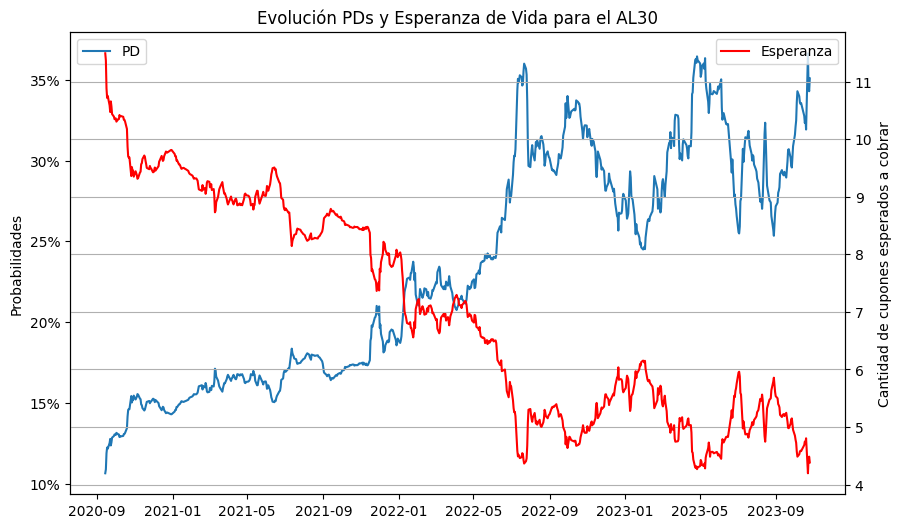

In [28]:
# Relación entre la evolución de las PDs y de la Esperanza de Vida

plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

plt.plot(PDs_Condicionales.index, PDs_Condicionales['AL30'], label= 'PD')
plt.legend()

# Formatear el eje y como porcentaje
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

plt.ylabel('Probabilidades')

plt.twinx()
plt.plot(Bonos_Esperanza.index, Bonos_Esperanza['AL30'], color='r', label= 'Esperanza')


# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Evolución PDs y Esperanza de Vida para el AL30')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de cupones esperados a cobrar')
plt.grid(True)


# Mostrar el gráfico
plt.show()

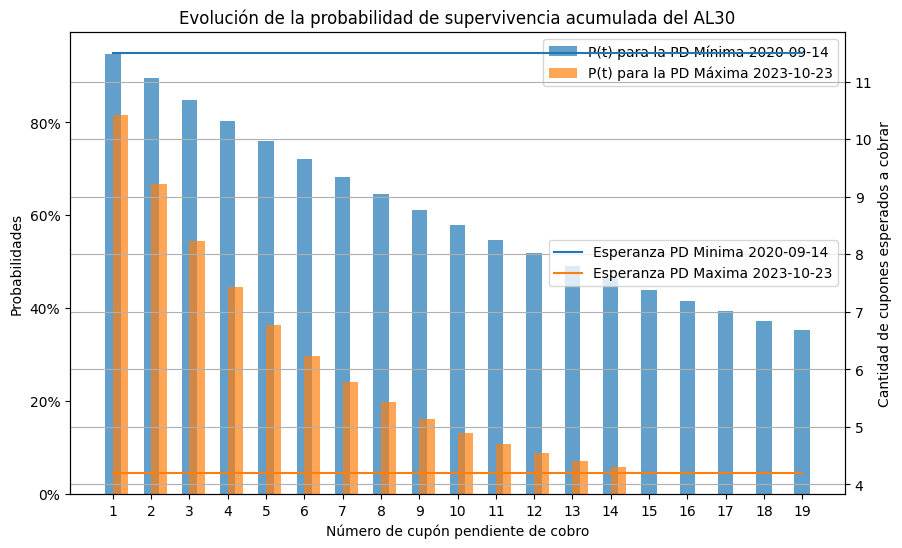

In [58]:
#Armo la evolución de las probabilidades de supervivencia para el AL30 y cuál es su esperanza de vida para la
#fecha en la cual fue minima y máxima la PD

PDs_AL30 = PDs_Cond_LocalLaw['AL30'].copy()

PD_Maxima = Prob_Superv('AL30', PDs_AL30.idxmax(), PDs_Condicionales)
PD_Minima = Prob_Superv('AL30', PDs_AL30.idxmin(), PDs_Condicionales)


plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

plt.bar(range(1, len(PD_Minima)+1), PD_Minima, width=0.4, label= f'P(t) para la PD Mínima {PDs_AL30.idxmin().date()}', align='center', alpha=0.7)
plt.bar(range(1, len(PD_Maxima)+1), PD_Maxima, width=0.4, label= f'P(t) para la PD Máxima {PDs_AL30.idxmax().date()}', align='edge', alpha=0.7)

plt.xlabel('Número de cupón pendiente de cobro')
plt.ylabel('Probabilidades')

# Formatear el eje y como porcentaje
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend()

plt.twinx()
plt.plot(range(1, len(PD_Minima)+1), [VidaMediaEsperada('AL30', PDs_AL30.idxmin(), PDs_Condicionales) for i in range(len(PD_Minima))] , label= f'Esperanza PD Minima {PDs_AL30.idxmin().date()}')
plt.plot(range(1, len(PD_Minima)+1), [VidaMediaEsperada('AL30', PDs_AL30.idxmax(), PDs_Condicionales) for i in range(len(PD_Minima))] , label= f'Esperanza PD Maxima {PDs_AL30.idxmax().date()}')

#plt.legend()

#plt.twinx()
#plt.plot(Bonos_Esperanza.index, Bonos_Esperanza['AL30'], color='r', label= 'Esperanza')

plt.xticks(range(1, len(PD_Minima)+1))

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('Evolución de la probabilidad de supervivencia acumulada del AL30')
plt.xlabel('Número de cupón pendiente de cobro')
plt.ylabel('Cantidad de cupones esperados a cobrar')
plt.grid(True)

# Mostrar el gráfico
plt.show()


COMPARACIÓN ENTRE AMBOS MODELOS

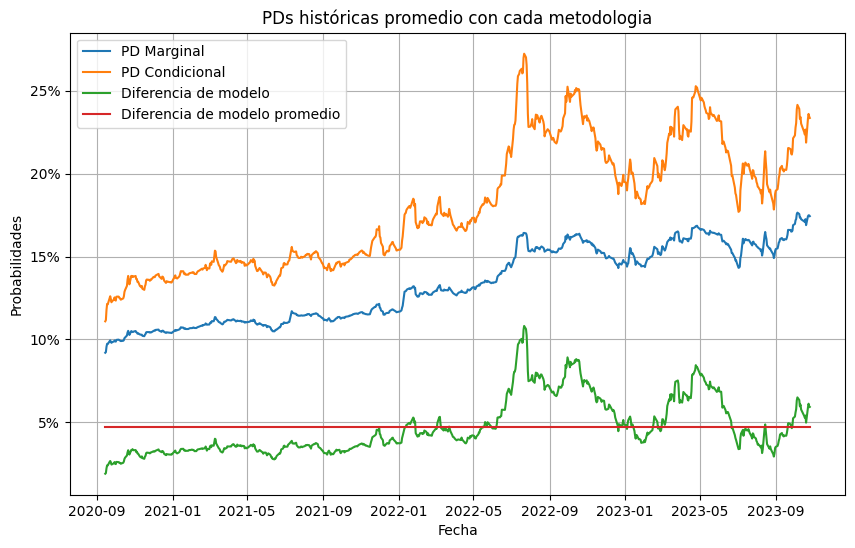

In [30]:
#Graficar La probabilidad promedio de lo que es Marginal y Condicional, el GAP entre ambas y  el GAP promedio histórico

Model_Gap = PDs_Cond - PDs_Mg

# Crear un gráfico de líneas para cada serie con leyenda
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar cada serie y agregar una leyenda

plt.plot(PDs_Mg.index, PDs_Mg, label='PD Marginal')
plt.plot(PDs_Cond.index, PDs_Cond, label='PD Condicional')
plt.plot(Model_Gap.index, Model_Gap, label='Diferencia de modelo')
plt.plot(Model_Gap.index, [Model_Gap.mean() for j in range(len(Model_Gap.index))], label='Diferencia de modelo promedio')

# Agregar una leyenda
plt.legend()

# Personalizar el gráfico
plt.title('PDs históricas promedio con cada metodologia')
plt.xlabel('Fecha')
plt.ylabel('Probabilidades')
plt.grid(True)

# Formatear el eje y como porcentaje
formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.show()


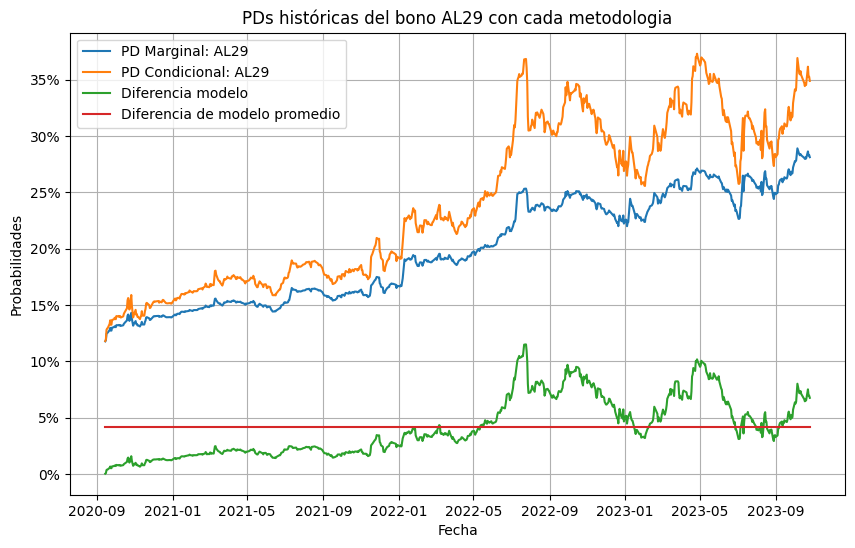

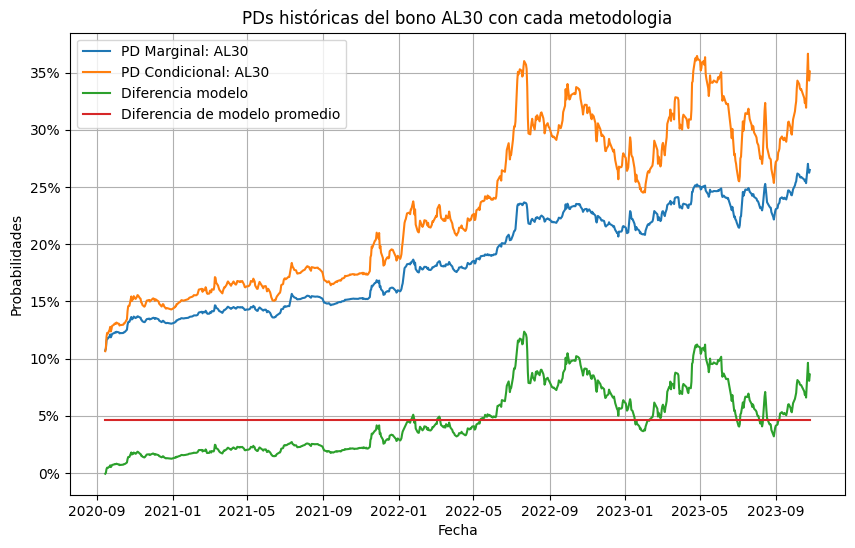

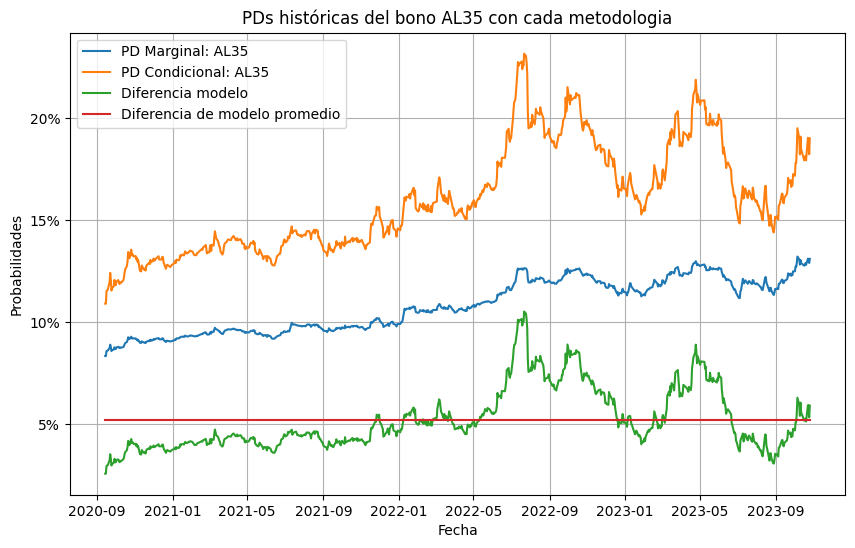

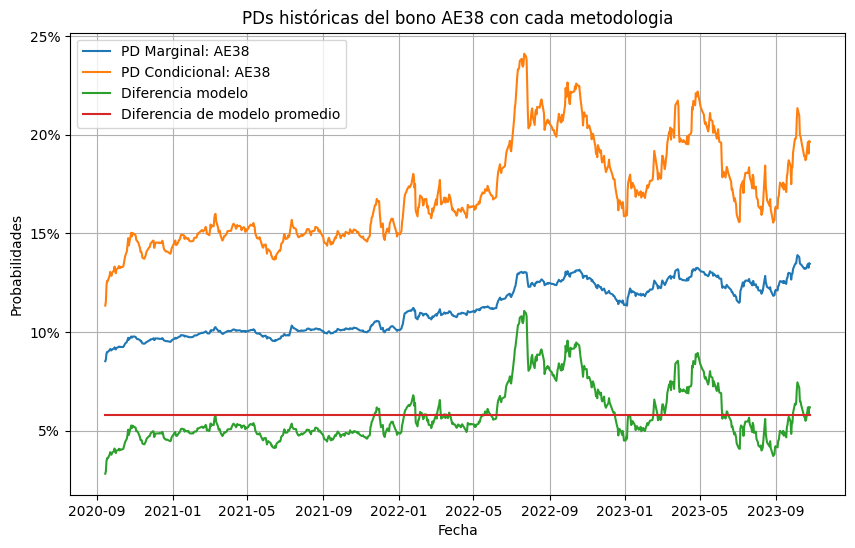

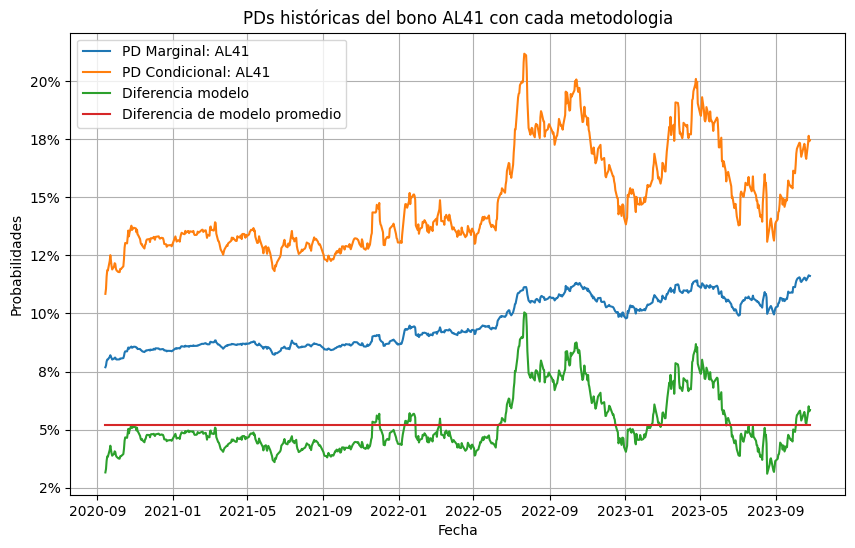

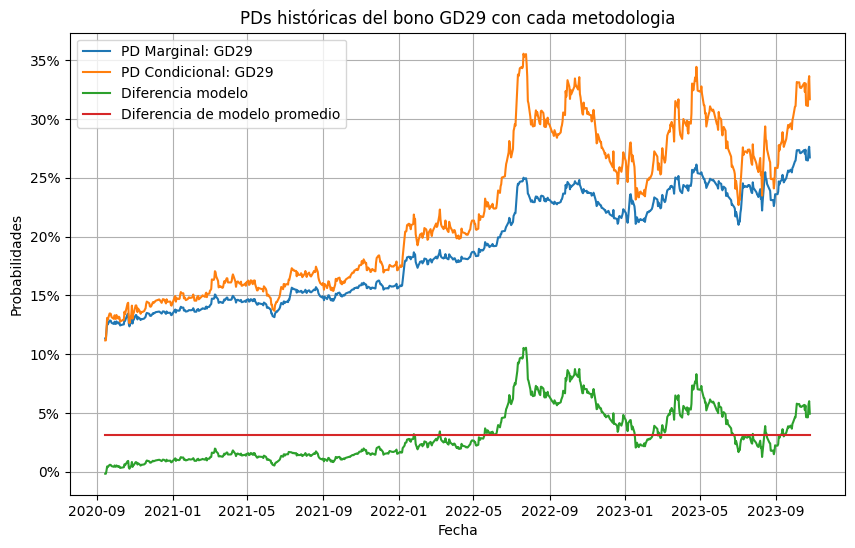

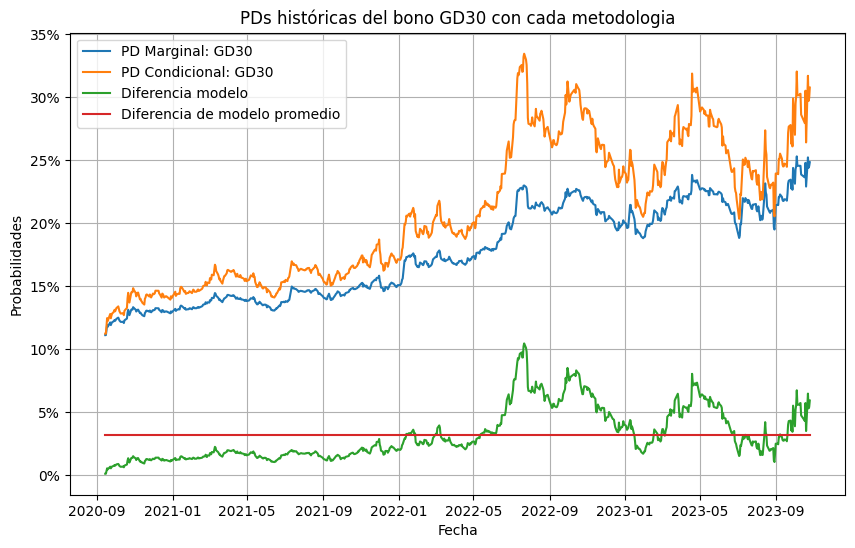

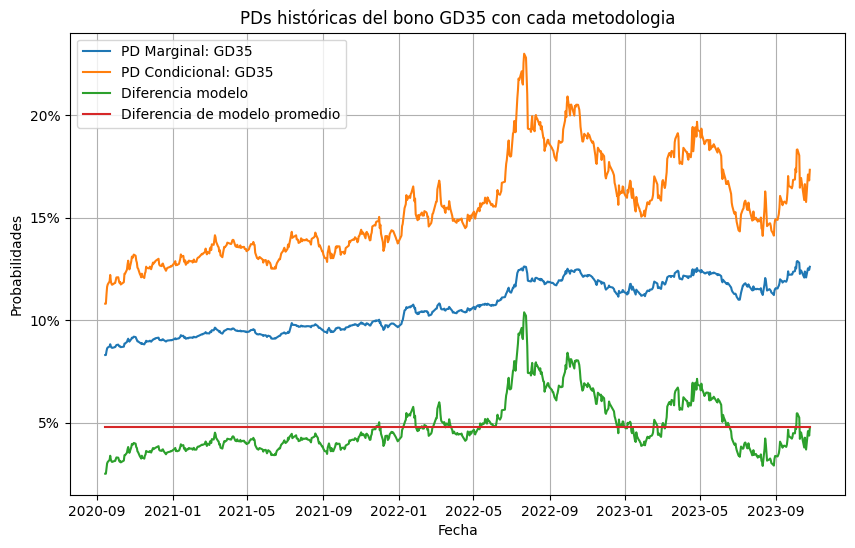

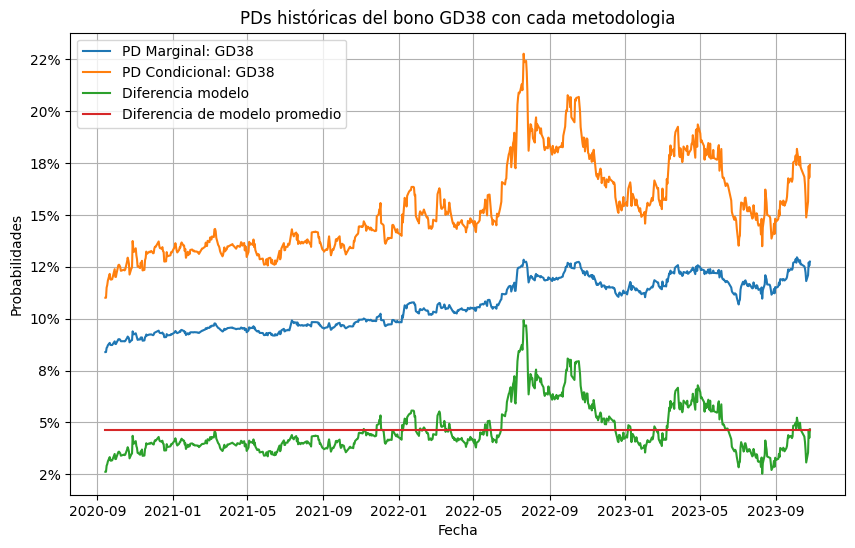

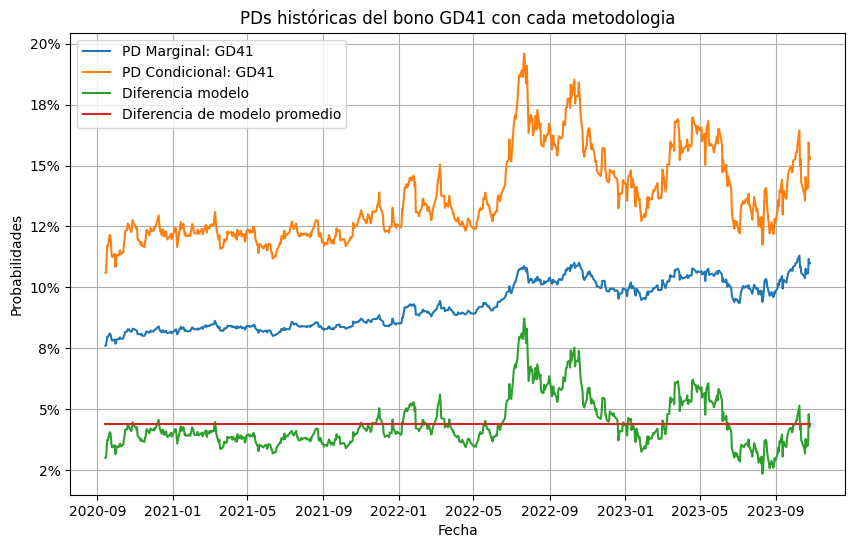

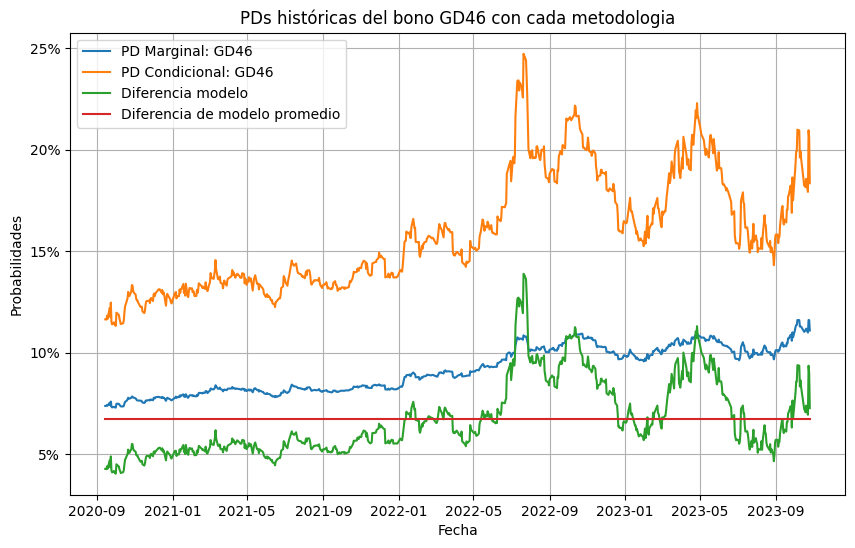

    Bond  Diferencia
0   AL29    0.041604
1   AL30    0.046312
2   AL35    0.052015
3   AE38    0.057942
4   AL41    0.052129
5   GD29    0.030979
6   GD30    0.032047
7   GD35    0.047866
8   GD38    0.046129
9   GD41    0.043765
10  GD46    0.067152
Diferencia Media de Modelos Total: 0.04708555234789059


In [31]:
#Grafico para cada bono los cálculos de cada probabilidad y el gap correspondiente

# Graficar cada serie y agregar una leyenda

for i in PDs_Marginales.columns:
    plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura
    plt.plot(PDs_Marginales.index, PDs_Marginales[i], label= f"PD Marginal: {i}")
    plt.plot(PDs_Condicionales.index, PDs_Condicionales[i], label=f"PD Condicional: {i}")
    plt.plot(PDs_Condicionales.index, PDs_Condicionales[i]- PDs_Marginales[i], label=f"Diferencia modelo")
    plt.plot(PDs_Condicionales.index, [(PDs_Condicionales[i]- PDs_Marginales[i]).mean() for j in range(len(PDs_Condicionales.index))], label=f"Diferencia de modelo promedio")


    # Agregar una leyenda
    plt.legend()

    # Personalizar el gráfico
    plt.title(f'PDs históricas del bono {i} con cada metodologia')
    plt.xlabel('Fecha')
    plt.ylabel('Probabilidades')
    plt.grid(True)

    # Formatear el eje y como porcentaje
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
    plt.gca().yaxis.set_major_formatter(formatter)

    # Mostrar el gráfico
    plt.show()


#Armo data Frame con Gaps entre las probabilidades de cada modelo

Diferencia_Modelo_Media = {'Bond' : [i for i in PDs_Marginales.columns],
        'Diferencia' : [(PDs_Condicionales[i]- PDs_Marginales[i]).mean() for i in PDs_Marginales.columns]}

Diferencia_Modelo_Media = pd.DataFrame(Diferencia_Modelo_Media)
print(Diferencia_Modelo_Media)
print(f"Diferencia Media de Modelos Total: {Diferencia_Modelo_Media['Diferencia'].mean()}")



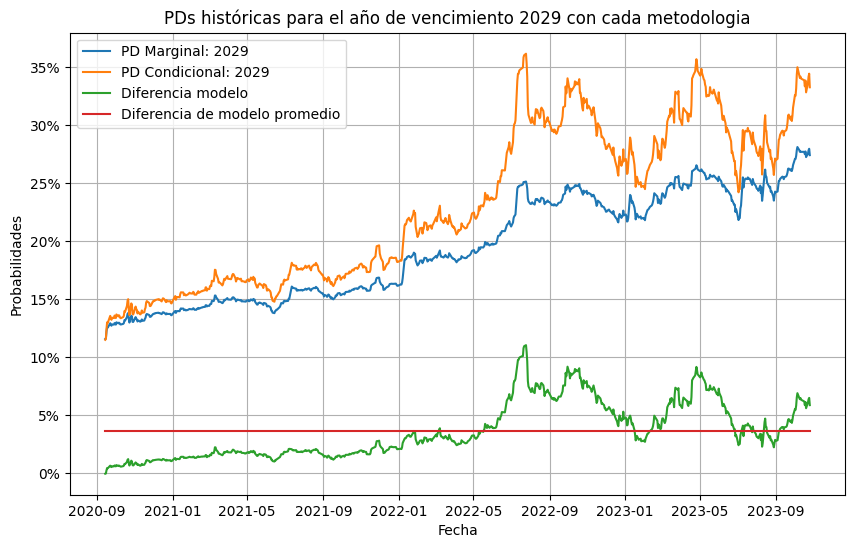

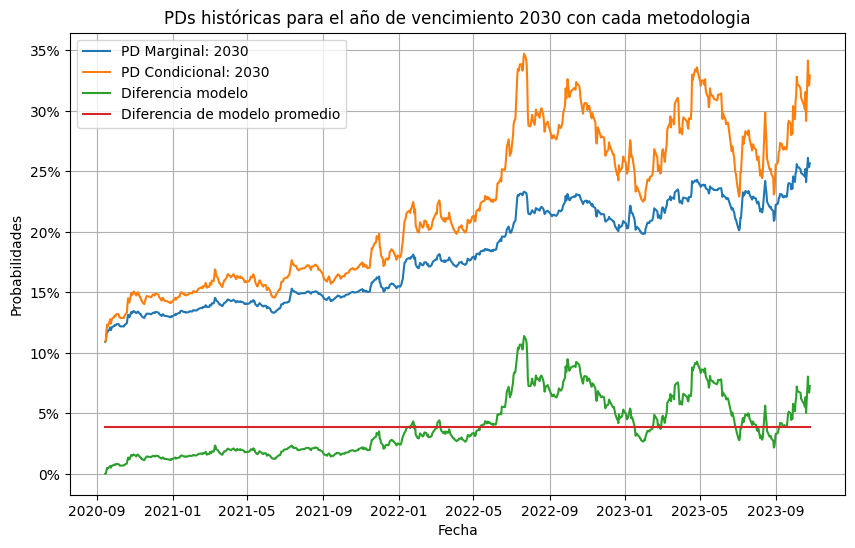

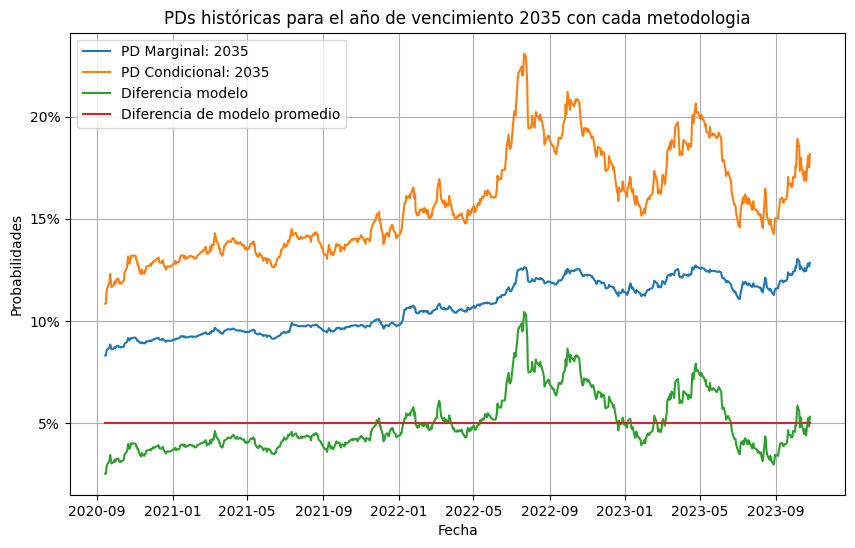

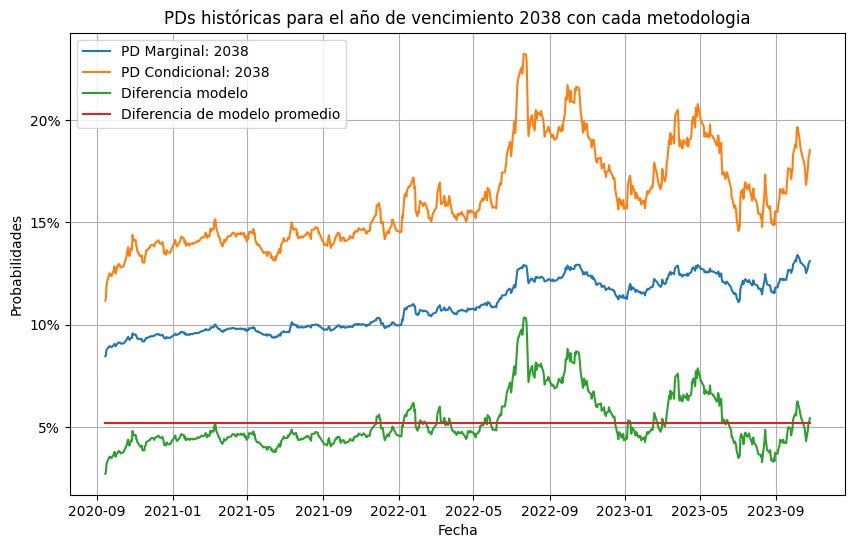

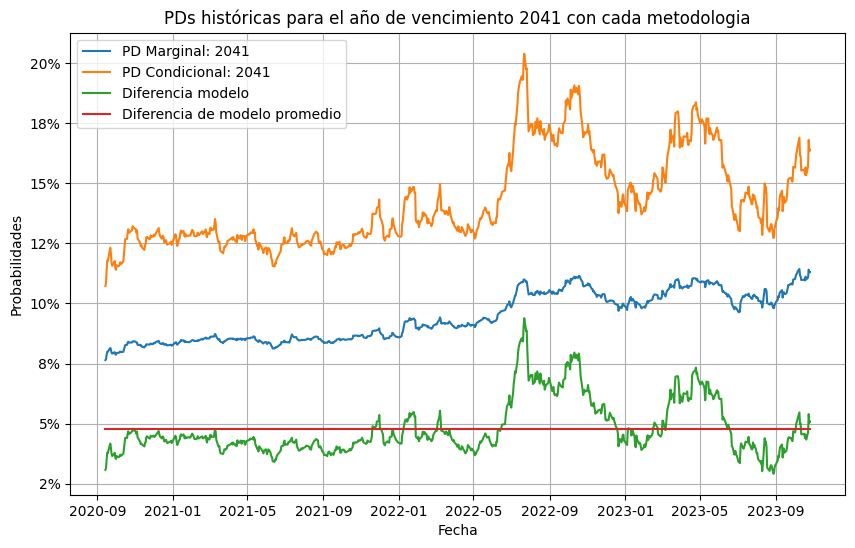

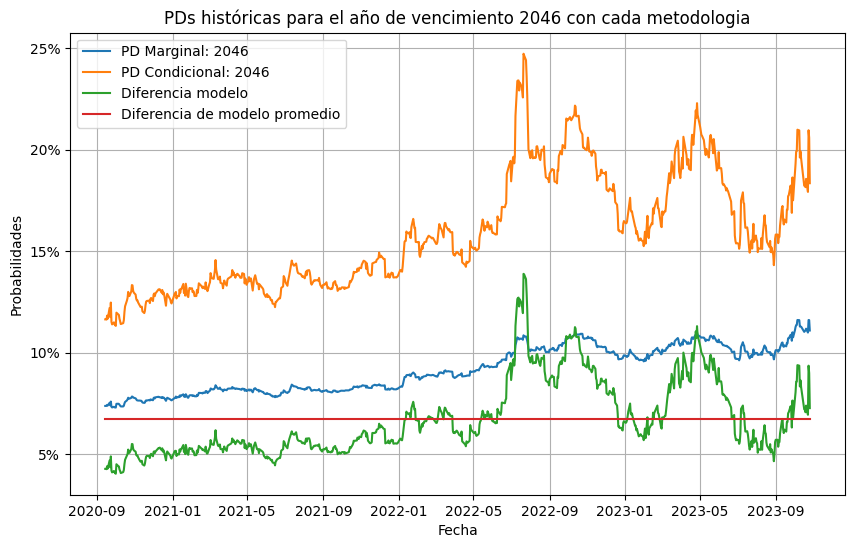

    Año  Diferencia
0  2029    0.036292
1  2030    0.039179
2  2035    0.049940
3  2038    0.052036
4  2041    0.047947
5  2046    0.067152
Diferencia Media de Modelos Total: 0.048757764718272874


In [32]:
# Grafico para cada año la evolución de las PDs de cada metodología y el gap entre ambas

PDs_2029 = pd.DataFrame()
PDs_2029['Marginal'] = PDs_Marginales[['AL29', 'GD29']].copy().mean(axis=1)
PDs_2029['Condicional'] = PDs_Condicionales[['AL29', 'GD29']].copy().mean(axis=1)
PDs_2029['Diferencia Modelo'] = PDs_2029['Condicional'] - PDs_2029['Marginal']

PDs_2030 = pd.DataFrame()
PDs_2030['Marginal'] = PDs_Marginales[['AL30', 'GD30']].copy().mean(axis=1)
PDs_2030['Condicional'] = PDs_Condicionales[['AL30', 'GD30']].copy().mean(axis=1)
PDs_2030['Diferencia Modelo'] = PDs_2030['Condicional'] - PDs_2030['Marginal']

PDs_2035 = pd.DataFrame()
PDs_2035['Marginal'] = PDs_Marginales[['AL35', 'GD35']].copy().mean(axis=1)
PDs_2035['Condicional'] = PDs_Condicionales[['AL35', 'GD35']].copy().mean(axis=1)
PDs_2035['Diferencia Modelo'] = PDs_2035['Condicional'] - PDs_2035['Marginal']

PDs_2038 = pd.DataFrame()
PDs_2038['Marginal'] = PDs_Marginales[['AE38', 'GD38']].copy().mean(axis=1)
PDs_2038['Condicional'] = PDs_Condicionales[['AE38', 'GD38']].copy().mean(axis=1)
PDs_2038['Diferencia Modelo'] = PDs_2038['Condicional'] - PDs_2038['Marginal']

PDs_2041 = pd.DataFrame()
PDs_2041['Marginal'] = PDs_Marginales[['AL41', 'GD41']].copy().mean(axis=1)
PDs_2041['Condicional'] = PDs_Condicionales[['AL41', 'GD41']].copy().mean(axis=1)
PDs_2041['Diferencia Modelo'] = PDs_2041['Condicional'] - PDs_2041['Marginal']

PDs_2046 = pd.DataFrame()
PDs_2046['Marginal'] = PDs_Marginales[['GD46']].copy().mean(axis=1)
PDs_2046['Condicional'] = PDs_Condicionales[['GD46']].copy().mean(axis=1)
PDs_2046['Diferencia Modelo'] = PDs_2046['Condicional'] - PDs_2046['Marginal']

PDs_Anuales = {'2029': PDs_2029, '2030': PDs_2030, '2035': PDs_2035, '2038': PDs_2038, '2041': PDs_2041, '2046': PDs_2046}

for i in PDs_Anuales.keys():
    plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura
    plt.plot(PDs_Anuales[i].index, PDs_Anuales[i]['Marginal'], label= f"PD Marginal: {i}")
    plt.plot(PDs_Anuales[i].index, PDs_Anuales[i]['Condicional'], label=f"PD Condicional: {i}")
    plt.plot(PDs_Anuales[i].index, PDs_Anuales[i]['Diferencia Modelo'], label=f"Diferencia modelo")
    plt.plot(PDs_Anuales[i].index, [PDs_Anuales[i]['Diferencia Modelo'].mean() for j in range(len(PDs_Anuales[i].index))], label=f"Diferencia de modelo promedio")


    # Agregar una leyenda
    plt.legend()

    # Personalizar el gráfico
    plt.title(f'PDs históricas para el año de vencimiento {i} con cada metodologia')
    plt.xlabel('Fecha')
    plt.ylabel('Probabilidades')
    plt.grid(True)

    # Formatear el eje y como porcentaje
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
    plt.gca().yaxis.set_major_formatter(formatter)




    # Mostrar el gráfico
    plt.show()


#Armo data Frame con Gaps entre las probabilidades de año

Diferencia_Modelo_Media = {'Año' : [i for i in PDs_Anuales.keys()],
        'Diferencia' : [PDs_Anuales[i]['Diferencia Modelo'].mean() for i in PDs_Anuales.keys()]}

Diferencia_Modelo_Media = pd.DataFrame(Diferencia_Modelo_Media)
print(Diferencia_Modelo_Media)
print(f"Diferencia Media de Modelos Total: {Diferencia_Modelo_Media['Diferencia'].mean()}")





In [33]:
# Correlaciones vs Riesgo País para confirmar que sea una buena estimación del riesgo de default y que se encuentre alineado con dicho indicador

Correlation_LocalLaw = {'Bono' : [i for i in Bonds_LocalLaw],
        'Correlación Marginal' : [CR['ARG'].corr(PDs_LocalLaw[i]) for i in Bonds_LocalLaw]}

Correlation_LocalLaw = pd.DataFrame(Correlation_LocalLaw)


Correlation_ForeignLaw = {'Bono' : [i for i in Bonds_ForeignLaw],
        'Correlación Marginal' : [CR['ARG'].corr(PDs_ForeignLaw[i]) for i in Bonds_ForeignLaw]}

Correlation_ForeignLaw = pd.DataFrame(Correlation_ForeignLaw)

Correlacion_Marginal = pd.concat([Correlation_LocalLaw, Correlation_ForeignLaw], ignore_index=True)
Correlacion_Marginal


Correlation_LocalLaw = {'Bono' : [i for i in Bonds_LocalLaw],
        'Correlación Condicional' : [CR['ARG'].corr(PDs_Cond_LocalLaw[i]) for i in Bonds_LocalLaw]}

Correlation_LocalLaw = pd.DataFrame(Correlation_LocalLaw)


Correlation_ForeignLaw = {'Bono' : [i for i in Bonds_ForeignLaw],
        'Correlación Condicional' : [CR['ARG'].corr(PDs_Cond_ForeignLaw[i]) for i in Bonds_ForeignLaw]}

Correlation_ForeignLaw = pd.DataFrame(Correlation_ForeignLaw)
Correlacion_Condicional = pd.concat([Correlation_LocalLaw, Correlation_ForeignLaw], ignore_index=True)
Correlacion_Condicional

Correlacion = pd.merge(Correlacion_Marginal, Correlacion_Condicional, on='Bono', how='left' )
Correlacion['Diferencia'] = Correlacion['Correlación Marginal'] - Correlacion['Correlación Condicional']
print(Correlacion)

print(f'Valores Promedios:')
Correlacion.iloc[:, 1:].mean()

#Correlacion.to_excel('C:/Users/juana/OneDrive/UCEMA/Quant - Finanzas Cuantitativas/TP Final/GitHub/tp_quant_Git Desktop/Correlación.xlsx', index=True)

    Bono  Correlación Marginal  Correlación Condicional  Diferencia
0   AL29              0.909485                 0.962274   -0.052789
1   AL30              0.915257                 0.964324   -0.049067
2   AL35              0.953339                 0.964627   -0.011287
3   AE38              0.946579                 0.955287   -0.008708
4   AL41              0.943730                 0.933401    0.010330
5   GD29              0.928170                 0.973899   -0.045729
6   GD30              0.944521                 0.983622   -0.039100
7   GD35              0.957987                 0.959552   -0.001565
8   GD38              0.960659                 0.947356    0.013303
9   GD41              0.963682                 0.928025    0.035657
10  GD46              0.954461                 0.969917   -0.015457
Valores Promedios:


Correlación Marginal       0.943443
Correlación Condicional    0.958389
Diferencia                -0.014947
dtype: float64